## Gorda Ridge data compilation & analysis
S. Hu Sept 2020

In [1]:
library(tidyverse); library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




### Import raw count data and relevent metadata

In [2]:
# Metadata for each grazing experiment
### Including dive ID, vent/site name, incubation parameters
exp_list <- read.table("data-input/Table1_grazingexp_list.txt",header=T, fill=T, sep="\t")
exp_IDs <- exp_list %>%
    separate(Sample.ID, c("Cruise", "SampleNumber"), "-", remove = FALSE) %>% 
    data.frame #Split column
# head(exp_IDs[1:3,])

# Import all cell count information from FLP disappearance experiments
counts <- read.csv("data-input/GordaRidge-cell-count-results.csv")
counts_df <- counts %>%
    separate(Site, c("SampleOrigin", "SampleNumber", "Stain"), "-", remove = FALSE) %>%
    separate(ID, c("TimePoint", "Bottle", "Replicate"), "-", remove = FALSE) %>%
    data.frame
# head(counts_df[1:3,])


# Import prok counts
prok<-read.table("data-input/prok_counts.txt",header=T, fill=T, sep="\t"); head(prok[1:2,])

,Sample_Num,Specific_Site,Sample.location,Prok_count,Vent.name
,<fct>,<fct>,<fct>,<dbl>,<fct>
1,NA108-036,Plume036,Plume,76899.49,Mt Edwards2
2,NA108-013,Mt Edwards,Vent,76206.70,Mt Edwards


In [3]:
# Join count data with experiment IDs so each vent site can be identified by name:
counts_df_ids <- counts_df %>%
    left_join(exp_IDs) %>%
    unite(Sample, TimePoint, Bottle, sep = "_", remove = FALSE) %>%
    data.frame
head(counts_df_ids) # View combined table
colnames(counts_df_ids)

Joining, by = "SampleNumber"



,Site,SampleOrigin,SampleNumber,Stain,ID,Sample,TimePoint,Bottle,Replicate,Cellsperml,⋯,T0,T18,T24,T36,T1,T2,Incubation.temp.min,Incubation.temp.max,Collection.temp.min,Collection.temp.max
,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,Plume-001-DTAF,Plume,001,DTAF,T0-Ctrl-R1,T0_Ctrl,T0,Ctrl,R1,53713.0,⋯,12:00:00 AM,,10:45:00 PM,11:00:00 AM,23,35,12,15,NA,NA
2,Plume-001-DTAF,Plume,001,DTAF,T0-Ctrl-R2,T0_Ctrl,T0,Ctrl,R2,26342.7,⋯,12:00:00 AM,,10:45:00 PM,11:00:00 AM,23,35,12,15,NA,NA
3,Plume-001-DTAF,Plume,001,DTAF,T0-Exp-R1,T0_Exp,T0,Exp,R1,52452.8,⋯,12:00:00 AM,,10:45:00 PM,11:00:00 AM,23,35,12,15,NA,NA
4,Plume-001-DTAF,Plume,001,DTAF,T0-Exp-R2,T0_Exp,T0,Exp,R2,82538.4,⋯,12:00:00 AM,,10:45:00 PM,11:00:00 AM,23,35,12,15,NA,NA
5,Plume-001-DTAF,Plume,001,DTAF,T0-Exp-R3,T0_Exp,T0,Exp,R3,77025.3,⋯,12:00:00 AM,,10:45:00 PM,11:00:00 AM,23,35,12,15,NA,NA
6,Plume-001-DTAF,Plume,001,DTAF,T0-Exp-R4,T0_Exp,T0,Exp,R4,67259.3,⋯,12:00:00 AM,,10:45:00 PM,11:00:00 AM,23,35,12,15,NA,NA


[1] "Site"                      "SampleOrigin"             
 [3] "SampleNumber"              "Stain"                    
 [5] "ID"                        "Sample"                   
 [7] "TimePoint"                 "Bottle"                   
 [9] "Replicate"                 "Cellsperml"               
[11] "T"                         "Dive"                     
[13] "Sample.Location"           "Sample.ID"                
[15] "Cruise"                    "Vent.name"                
[17] "Depth..m."                 "Start.date"               
[19] "End.date"                  "Est..FLP.added..cells.mL."
[21] "T0"                        "T18"                      
[23] "T24"                       "T36"                      
[25] "T1"                        "T2"                       
[27] "Incubation.temp.min"       "Incubation.temp.max"      
[29] "Collection.temp.min"       "Collection.temp.max"

### Calculate Error rate to see which experiment we need to remove
Using sample Vent 110 T0-control, this was counted 3 times as a technical replicate

In [4]:
# Need to determine error rate across technical replicates. 
## Prepped a single sample 3 times (3 different days); this was counted separately to to estimate a personal error rate
# This is the % max and min that we will consider to be a margin of error
tech_check <- counts_df_ids %>%
    filter(Site %in% "Vent-110-DTAF" & TimePoint %in% "T0" & Bottle %in% "Ctrl" & !(Replicate %in% "R2")) %>%
    group_by(SampleOrigin, SampleNumber) %>%
    summarise(MEAN = mean(Cellsperml), STDEV = sd(Cellsperml), ERR_PER = (100*(STDEV/MEAN))) %>%
    data.frame

head(tech_check)
PERCENT_ERR <- tech_check[["ERR_PER"]]; PERCENT_ERR # Change in FLP time point to time point must exceed 16%

`summarise()` regrouping output by 'SampleOrigin' (override with `.groups` argument)



,SampleOrigin,SampleNumber,MEAN,STDEV,ERR_PER
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Vent,110,60381.13,9751.156,16.14934


[1] 16.14934

## From count data, calculate average cell/ml

In [5]:
# Get average FLP concentration from T0 experiments and average cells/ml from proj counts
# What else should I calculate count-to-count?
calc_FLP_avg <- counts_df_ids %>%
    group_by(SampleOrigin, SampleNumber, T, Bottle, Vent.name, Sample, Stain, T1, T2) %>%
    summarise(Avg_cellmL = mean(Cellsperml), # Average cells per ml across replicates
              sem=sd(Cellsperml)/sqrt(length(Cellsperml)), # Standard mean error
              SD=sd(Cellsperml),  #standard deviation
              var=sqrt(SD),  # variance
              Num = n()) %>% #Total number of 
    data.frame
# head(calc_FLP_avg)

`summarise()` regrouping output by 'SampleOrigin', 'SampleNumber', 'T', 'Bottle', 'Vent.name', 'Sample', 'Stain', 'T1' (override with `.groups` argument)



In [6]:
# Separate T0 from other time points to calculate % differences in DTAF counts from T0 to T1 and T0 to T2
t0 <- filter(calc_FLP_avg, (T == "T0" & Stain == "DTAF")) %>%
    select(-T1, -T2, -Stain, -Num, -T, -Sample, -SD, -var, Avg_cellmL_T0 = Avg_cellmL, sem_T0 = sem) %>%
    data.frame
# head(t0)

t_ex <- filter(calc_FLP_avg, (!(T == "T0") & Stain == "DTAF")) %>%
    select(-Stain, -Num, -Sample, -SD, -var) %>%
    pivot_wider(names_from = T, values_from = c(Avg_cellmL, sem)) %>%
    data.frame
# head(t_ex)
# ?pivot_wider

bac_exp <- calc_FLP_avg %>%
    filter(Stain %in% "DAPI") %>%
    select(-Bottle, -Stain, -T1, -T2, -SD, -var, -Num, bac_cellmL = Avg_cellmL, bac_sem = sem) %>%
    unite(SAMPLE, SampleOrigin, Vent.name, sep = "-", remove = FALSE) %>%
    data.frame
# head(bac_exp)
dapi<-as.character(unique(bac_exp$SAMPLE))
# dapi

prok_avg <- prok %>%
    group_by(Sample.location, Vent.name) %>%
    summarise(prok_avg = mean(Prok_count)) %>%
    unite(SAMPLE, Sample.location, Vent.name, sep = "-") %>%
    data.frame
# prok_avg

# Created:
# t0, t_ex, bac_exp, prok_avg
colnames(t0)

`summarise()` regrouping output by 'Sample.location' (override with `.groups` argument)



[1] "SampleOrigin"  "SampleNumber"  "Bottle"        "Vent.name"    
[5] "Avg_cellmL_T0" "sem_T0"

In [7]:
# Calculate percent difference between T0 and T1, and T1 and T2
flp_exp_summary <- t0 %>%
    left_join(t_ex) %>%
    unite(SAMPLE, SampleOrigin, Vent.name, sep = "-", remove = FALSE) %>%
    left_join(prok_avg) %>%
    mutate(T0_T1_PercDiff = 100*(abs(Avg_cellmL_T1-Avg_cellmL_T0)/Avg_cellmL_T0),
          T0_T2_PercDiff = 100*(abs(Avg_cellmL_T2-Avg_cellmL_T0)/Avg_cellmL_T0)) %>%
    data.frame
head(flp_exp_summary)

Joining, by = c("SampleOrigin", "SampleNumber", "Bottle", "Vent.name")

Joining, by = "SAMPLE"



,SAMPLE,SampleOrigin,SampleNumber,Bottle,Vent.name,Avg_cellmL_T0,sem_T0,T1,T2,Avg_cellmL_T1,Avg_cellmL_T2,sem_T1,sem_T2,prok_avg,T0_T1_PercDiff,T0_T2_PercDiff
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Plume-Mt Edwards,Plume,001,Ctrl,Mt Edwards,40027.85,13685.1500,23,35,71433.50,66235.50,78.80,6536.9000,51959.11,78.459498,65.473539
2,Plume-Mt Edwards,Plume,001,Exp,Mt Edwards,69818.95,6594.5107,23,35,65290.40,57808.35,3386.60,472.5500,51959.11,6.486133,17.202493
3,Vent-Mt Edwards,Vent,013,Ctrl,Mt Edwards,50556.80,13027.5642,24,36,53502.93,44577.05,12508.17,1260.1500,51439.52,5.827373,11.827786
4,Vent-Mt Edwards,Vent,013,Exp,Mt Edwards,60381.13,4786.6367,24,36,40639.10,29770.53,4095.40,510.4046,51439.52,32.695699,50.695651
5,Vent-Venti latte,Vent,043,Ctrl,Venti latte,47761.10,8224.6000,19,29,51271.45,52216.55,9687.25,2126.4500,111192.50,7.349810,9.328617
6,Vent-Venti latte,Vent,043,Exp,Venti latte,45154.57,670.3404,19,29,32448.30,37436.30,5670.60,2244.8518,111192.50,28.139494,17.092992


In [8]:
# Prep data frame to look at loss of FLP over time for all time points
## Compare to those that exceed error rate
PERCENT_ERR
# ?pivot_longer()
colnames(flp_exp_summary)

[1] 16.14934

[1] "SAMPLE"         "SampleOrigin"   "SampleNumber"   "Bottle"        
 [5] "Vent.name"      "Avg_cellmL_T0"  "sem_T0"         "T1"            
 [9] "T2"             "Avg_cellmL_T1"  "Avg_cellmL_T2"  "sem_T1"        
[13] "sem_T2"         "prok_avg"       "T0_T1_PercDiff" "T0_T2_PercDiff"

In [9]:
cells_long <- flp_exp_summary %>%
    select(SAMPLE, Bottle, Vent.name, Avg_cellmL_T0, Avg_cellmL_T1, Avg_cellmL_T2, T1, T2) %>%
    pivot_longer(cols = starts_with("Avg_cellmL"), names_to = "CountID", values_to = "cellmL") %>%
    separate(CountID, c("avg", "excess", "Tx"), sep = "_", remove = FALSE) %>%
    select(-avg, -excess) %>%
    data.frame

sem_long <- flp_exp_summary %>%
    select(SAMPLE, Bottle, Vent.name, sem_T0, sem_T1, sem_T2) %>%
    pivot_longer(cols = starts_with("sem"), names_to = "semID", values_to = "sem") %>%
    separate(semID, c("excess", "Tx"), sep = "_", remove = FALSE) %>%
    select(-excess) %>%
    data.frame

# head(cells_long); head(sem_long)

# Combine and fix Timepoint
flp_long_toplot <- cells_long %>%
    left_join(sem_long) %>%
    select(-semID) %>%
    add_column(Hrs = 0) %>%
    mutate(Hrs = case_when(
        Tx == "T1" ~ T1,
        Tx == "T2" ~ T2,
        TRUE ~ (as.integer(.$Hrs)))) %>%
    select(-T1, -T2) %>%
    data.frame

head(flp_long_toplot)

Joining, by = c("SAMPLE", "Bottle", "Vent.name", "Tx")



,SAMPLE,Bottle,Vent.name,CountID,Tx,cellmL,sem,Hrs
,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,Plume-Mt Edwards,Ctrl,Mt Edwards,Avg_cellmL_T0,T0,40027.85,13685.150,0
2,Plume-Mt Edwards,Ctrl,Mt Edwards,Avg_cellmL_T1,T1,71433.50,78.800,23
3,Plume-Mt Edwards,Ctrl,Mt Edwards,Avg_cellmL_T2,T2,66235.50,6536.900,35
4,Plume-Mt Edwards,Exp,Mt Edwards,Avg_cellmL_T0,T0,69818.95,6594.511,0
5,Plume-Mt Edwards,Exp,Mt Edwards,Avg_cellmL_T1,T1,65290.40,3386.600,23
6,Plume-Mt Edwards,Exp,Mt Edwards,Avg_cellmL_T2,T2,57808.35,472.550,35


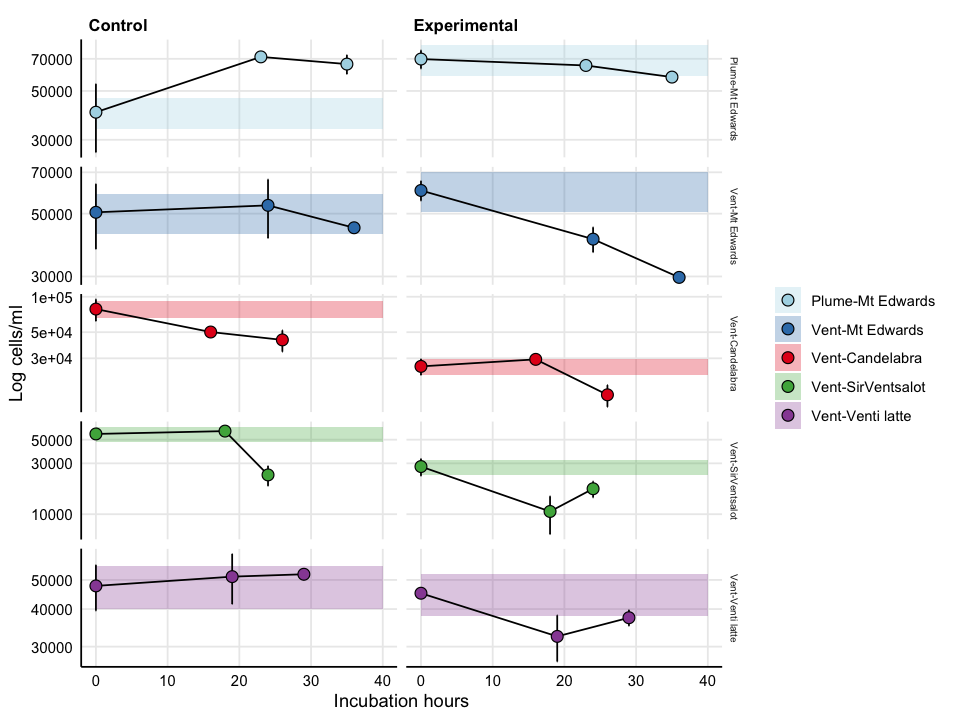

In [10]:
## Plot average cells/ml for each experiment

# Factor for plotting
sample_order <- c('Plume-Mt Edwards','Vent-Mt Edwards','Vent-Candelabra','Vent-SirVentsalot','Vent-Venti latte')
sample_color <-c("lightblue","#377eb8", "#e41a1c", "#4daf4a", "#984ea3")
flp_long_toplot$SAMPLE_ORDER <- factor(flp_long_toplot$SAMPLE, levels = (sample_order))
names(sample_color) <- sample_order
bottle_order <- c("Ctrl", "Exp")
flp_long_toplot$BOTTLE <- factor(flp_long_toplot$Bottle, levels = bottle_order, labels = c("Control", "Experimental"))

options(repr.plot.width = 8, repr.plot.height = 6) #set plot size output 

# svg("Supplementary-FLP-CTRL-PercError-plot.svg", w = 10, h = 8)
ggplot(flp_long_toplot, aes(x = Hrs, y = cellmL, fill = SAMPLE_ORDER)) +
    geom_rect(data = (subset(flp_long_toplot, Tx %in% "T0")), aes(xmin=0, xmax=40, 
            ymin=(cellmL - ((PERCENT_ERR/100)*cellmL)), 
            ymax=(cellmL + ((PERCENT_ERR/100)*cellmL))), color=NA,alpha=0.3) +
    geom_line(stat = "identity", linetype = 1, aes(group = SAMPLE)) +
    geom_errorbar(aes(ymin = (cellmL - sem), ymax = (cellmL + sem)), width = 0.1) +
    geom_point(stat = "identity", size = 3, color = "black", shape = 21, aes(fill = SAMPLE)) +
    scale_y_log10() +
    scale_fill_manual(values = sample_color) +
    labs(y = "Log cells/ml", x = "Incubation hours") +
    facet_grid(SAMPLE_ORDER~BOTTLE, scales = "free") +
    theme_minimal() + 
    theme(panel.grid.minor = element_blank(),
          legend.title = element_blank(),
          strip.text.x = element_text(face = "bold", color = "black", hjust = 0, size = 10),
          strip.text.y = element_text(size = 6),
          panel.background = element_blank(), axis.line = element_line(colour = "black"), 
          axis.text = element_text(color = "black", size = 9))
# dev.off()

## Refine FLP count results
#### Subset flp results to only grab the FLP experiments with significant changes

In [11]:
# Subset Experiment results and filter for those that exceed the percent error
flp_sig <- flp_exp_summary %>%
    filter(Bottle %in% "Exp") %>%
    select(-T1, -T2) %>%
    mutate(T1_sig = case_when(
        T0_T1_PercDiff > PERCENT_ERR ~ "exceeds"),
           T2_sig = case_when(T0_T2_PercDiff > PERCENT_ERR ~ "exceeds")
          ) %>%
    data.frame

# head(flp_sig)

# Select experiments that T1 exceeds percent difference
T1_tmp <- flp_sig %>%
    filter(T1_sig == "exceeds") %>%
    select(SAMPLE) %>%
    data.frame
T1_tmp$Tx = "T1"
T1_tmp$Keep = "yes"

# Select experiments that T1 was NA, but T2 was significant
T2_tmp <- flp_sig %>%
    filter(is.na(T1_sig) & T2_sig == "exceeds") %>%
    select(SAMPLE) %>%
    data.frame
T2_tmp$Tx = "T2"
T2_tmp$Keep = "yes"

keep_status <- rbind(T1_tmp, T2_tmp); keep_status

# # KEPT:
# # plume time point T2, Candelabra T2
# # Mt Edwards time point T1, Sirventsalot T1, & venti latte T1

SAMPLE,Tx,Keep
<chr>,<chr>,<chr>
Vent-Mt Edwards,T1,yes
Vent-Venti latte,T1,yes
Vent-SirVentsalot,T1,yes
Plume-Mt Edwards,T2,yes
Vent-Candelabra,T2,yes


In [12]:
# Join experiments that are significant and filter data to keep.
t <- c("T1", "T2")
flp_trend_sig <- flp_long_toplot %>%
    filter(Bottle == "Exp") %>%
    left_join(keep_status) %>%
    filter(Tx == "T0" | (Tx %in% t & Keep == "yes")) %>%
    separate(SAMPLE, c("SampleOrigin", "excess"), sep = "-", remove = FALSE) %>%
    select(-Keep, -excess) %>%
    data.frame
flp_trend_sig

Joining, by = c("SAMPLE", "Tx")



SAMPLE,SampleOrigin,Bottle,Vent.name,CountID,Tx,cellmL,sem,Hrs,SAMPLE_ORDER,BOTTLE
<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<fct>,<fct>
Plume-Mt Edwards,Plume,Exp,Mt Edwards,Avg_cellmL_T0,T0,69818.95,6594.5107,0,Plume-Mt Edwards,Experimental
Plume-Mt Edwards,Plume,Exp,Mt Edwards,Avg_cellmL_T2,T2,57808.35,472.5500,35,Plume-Mt Edwards,Experimental
Vent-Mt Edwards,Vent,Exp,Mt Edwards,Avg_cellmL_T0,T0,60381.13,4786.6367,0,Vent-Mt Edwards,Experimental
Vent-Mt Edwards,Vent,Exp,Mt Edwards,Avg_cellmL_T1,T1,40639.10,4095.4000,24,Vent-Mt Edwards,Experimental
Vent-Venti latte,Vent,Exp,Venti latte,Avg_cellmL_T0,T0,45154.57,670.3404,0,Vent-Venti latte,Experimental
Vent-Venti latte,Vent,Exp,Venti latte,Avg_cellmL_T1,T1,32448.30,5670.6000,19,Vent-Venti latte,Experimental
Vent-Candelabra,Vent,Exp,Candelabra,Avg_cellmL_T0,T0,25622.60,3964.4107,0,Vent-Candelabra,Experimental
Vent-Candelabra,Vent,Exp,Candelabra,Avg_cellmL_T2,T2,14701.50,3079.0783,26,Vent-Candelabra,Experimental
Vent-SirVentsalot,Vent,Exp,SirVentsalot,Avg_cellmL_T0,T0,27985.33,5055.5143,0,Vent-SirVentsalot,Experimental


### Plot FLP loss trend of experiments which exceeded percent error:

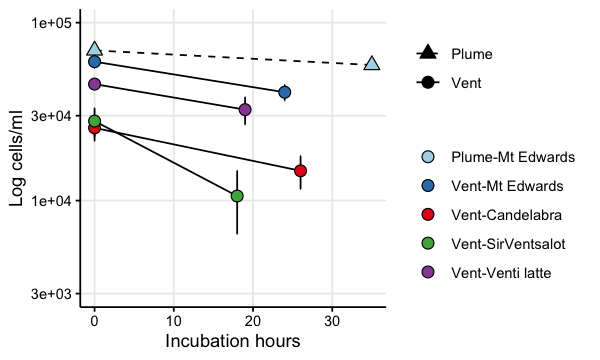

In [13]:
# # Factor (redundant to previous plot);factored columns remain in data frame
# sample_order <- c('Plume-Mt Edwards','Vent-Mt Edwards','Vent-Candelabra','Vent-SirVentsalot','Vent-Venti latte')
# sample_color <-c("lightblue","#377eb8", "#e41a1c", "#4daf4a", "#984ea3")
# plot_flp_df$SAMPLE_ORDER <- factor(plot_flp_df$SAMPLE, levels = (sample_order))

options(repr.plot.width = 5, repr.plot.height = 3) #set plot size output 

plot_graze_trends <- ggplot(flp_trend_sig, 
                            aes(x = Hrs, y = cellmL, fill = SAMPLE_ORDER, shape = SampleOrigin)) +
    geom_line(stat="identity", aes(group = SAMPLE_ORDER, linetype = SampleOrigin)) +
    geom_errorbar(aes(ymin = (cellmL-sem), ymax = (cellmL+sem)), size = 0.5, width = 0.1)+
    geom_point(stat="identity", size=3, color="black") +
    scale_linetype_manual(values = c(2, 1))+
    scale_fill_manual(values = sample_color)+
    scale_shape_manual(values = c(24,21))+
    scale_y_log10(limits = c(3e3,1e5))+
    labs(y="Log cells/ml", x = "Incubation hours")+
    theme_minimal()+
    theme(panel.grid.major = element_line(), panel.grid.minor = element_blank(),
           panel.background = element_blank(), axis.line = element_line(colour = "black"), 
           axis.text=element_text(color="black"), axis.ticks = element_line(),
           legend.title = element_blank()) +
    guides(fill = guide_legend(override.aes = list(shape = 21)),
       shape = guide_legend(override.aes = list(fill = "black")))

plot_graze_trends

### Calculate/plot grazing rate & prokaryote turnover % per day

In [14]:
# Change time point label structure, as each experiments lists T0 or TF
processed_data <- flp_trend_sig %>%
    mutate(TimePoint = case_when(Tx == "T0" ~ "T0",
                                Tx != "T0" ~ "Tf")) %>%
    select(-Tx, -CountID) %>%
    pivot_wider(names_from = TimePoint, values_from = c(cellmL, sem, Hrs)) %>%
    select(-Hrs_T0) %>%
    left_join(prok_avg) %>%
    data.frame
processed_data

Joining, by = "SAMPLE"



SAMPLE,SampleOrigin,Bottle,Vent.name,SAMPLE_ORDER,BOTTLE,cellmL_T0,cellmL_Tf,sem_T0,sem_Tf,Hrs_Tf,prok_avg
<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Plume-Mt Edwards,Plume,Exp,Mt Edwards,Plume-Mt Edwards,Experimental,69818.95,57808.35,6594.5107,472.550,35,51959.11
Vent-Mt Edwards,Vent,Exp,Mt Edwards,Vent-Mt Edwards,Experimental,60381.13,40639.10,4786.6367,4095.400,24,51439.52
Vent-Venti latte,Vent,Exp,Venti latte,Vent-Venti latte,Experimental,45154.57,32448.30,670.3404,5670.600,19,111192.50
Vent-Candelabra,Vent,Exp,Candelabra,Vent-Candelabra,Experimental,25622.60,14701.50,3964.4107,3079.078,26,55076.66
Vent-SirVentsalot,Vent,Exp,SirVentsalot,Vent-SirVentsalot,Experimental,27985.33,10606.10,5055.5143,4108.875,18,52998.29


In [15]:
# Grazing rate calculation from Connell et al. 2017

# grazing rate = ln(Tf/T0) * (-1/t)
## t = incubation hours reported as days
## Tf = number of FLP at end of experiment
## T0 = number of FLP at beginning of experiment

## The natural log in R is 'log()'
# log(5)
# log10(5)

In [16]:
# Calculate grazing rates and prokaryote turnover percentage per day
#
graze_rate <- processed_data %>%
    group_by(SAMPLE, SampleOrigin, Vent.name, Hrs_Tf) %>%
    mutate(rate = (log(cellmL_Tf/cellmL_T0))*(-1/(Hrs_Tf/24)),
           rate_min = (log((cellmL_Tf-sem_Tf)/(cellmL_T0-sem_T0)))*(-1/(Hrs_Tf/24)),
           rate_max = (log((cellmL_Tf+sem_Tf)/(cellmL_T0+sem_T0)))*(-1/(Hrs_Tf/24)),
          Prok_turnover = 100*((rate * prok_avg)/prok_avg),
           Prok_turnover_min = 100*((rate_min * prok_avg)/prok_avg),
           Prok_turnover_max = 100*((rate_max * prok_avg)/prok_avg)
              ) %>%
        data.frame 
graze_rate

## Calculations not included:
# q  - proportion of bacteria grazed in experiment
## q_tp = ((cellmL_T0 - cellmL_Tf)/((cellmL_T0 + cellmL_Tf)/2)),
## G - are total number of bacteria grazed during experiment
# G_tp1 = ((cellmL_T0 - cellmL_Tf)*(prok_avg / cellmL_T0))

SAMPLE,SampleOrigin,Bottle,Vent.name,SAMPLE_ORDER,BOTTLE,cellmL_T0,cellmL_Tf,sem_T0,sem_Tf,Hrs_Tf,prok_avg,rate,rate_min,rate_max,Prok_turnover,Prok_turnover_min,Prok_turnover_max
<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Plume-Mt Edwards,Plume,Exp,Mt Edwards,Plume-Mt Edwards,Experimental,69818.95,57808.35,6594.5107,472.550,35,51959.11,0.1294438,0.06703935,0.1857493,12.94438,6.703935,18.57493
Vent-Mt Edwards,Vent,Exp,Mt Edwards,Vent-Mt Edwards,Experimental,60381.13,40639.10,4786.6367,4095.400,24,51439.52,0.3959460,0.41957541,0.3762200,39.59460,41.957541,37.62200
Vent-Venti latte,Vent,Exp,Venti latte,Vent-Venti latte,Experimental,45154.57,32448.30,670.3404,5670.600,19,111192.50,0.4174021,0.64113500,0.2325695,41.74021,64.113500,23.25695
Vent-Candelabra,Vent,Exp,Candelabra,Vent-Candelabra,Experimental,25622.60,14701.50,3964.4107,3079.078,26,55076.66,0.5127925,0.57456692,0.4700572,51.27925,57.456692,47.00572
Vent-SirVentsalot,Vent,Exp,SirVentsalot,Vent-SirVentsalot,Experimental,27985.33,10606.10,5055.5143,4108.875,18,52998.29,1.2936683,1.68141744,1.0785052,129.36683,168.141744,107.85052


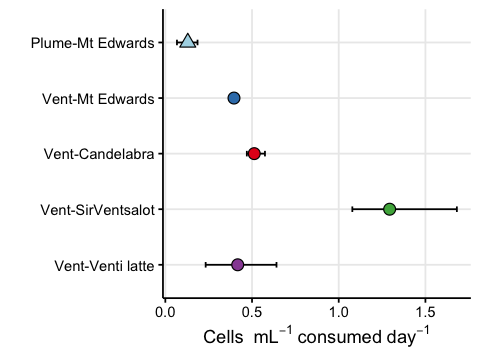

In [17]:
# Plot grazing rates with error bar
options(repr.plot.width = 4, repr.plot.height = 3)

# Re-factor - reverse color and order
sample_order <- c('Plume-Mt Edwards','Vent-Mt Edwards','Vent-Candelabra','Vent-SirVentsalot','Vent-Venti latte')
sample_color <-c("lightblue","#377eb8", "#e41a1c", "#4daf4a", "#984ea3")
graze_rate$SAMPLE_ORDER <- factor(graze_rate$SAMPLE, levels = rev(sample_order))

mortality <- ggplot(graze_rate, aes(x = SAMPLE_ORDER, y = rate, fill = SAMPLE_ORDER, shape = SampleOrigin)) + 
    geom_errorbar(aes(ymin = rate_min, ymax = rate_max), size = 0.5, width = 0.1) +
    geom_point(stat = "identity", size = 3, color = "black", aes(shape = SampleOrigin)) +
    scale_fill_manual(values = rev(sample_color)) +
    scale_shape_manual(values = c(24,21)) +
    coord_flip() +
    labs(x = "", y = bquote("Cells "~mL^-1 ~consumed ~day^-1)) +
    theme_minimal() +
    theme(panel.grid.major = element_line(), panel.grid.minor = element_blank(),
           panel.background = element_blank(), axis.line = element_line(colour = "black"), 
           axis.text=element_text(color="black"), axis.ticks = element_line(),
           legend.position = "none", strip.text =element_blank())

mortality

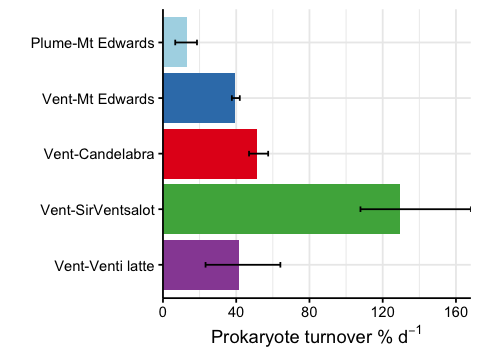

In [18]:
# Plot turnover:
options(repr.plot.width = 4, repr.plot.height = 3)
bar_plot <- ggplot(graze_rate, aes(x = SAMPLE_ORDER, y = Prok_turnover)) +
    geom_bar(stat = "identity", position = "stack", aes(fill = SAMPLE_ORDER)) +
    geom_errorbar(aes(ymin = Prok_turnover_min, ymax = Prok_turnover_max), size = 0.5, width = 0.1) +
    scale_fill_manual(values = rev(sample_color)) +
    scale_y_continuous(expand = c(0,0)) +
    labs(x = "", y = bquote("Prokaryote turnover %"~d^-1)) +
    coord_flip() +
    theme_minimal() +
    theme(panel.grid.major = element_line(),
           panel.background = element_blank(), axis.line = element_line(colour = "black"), 
           axis.text=element_text(color="black"), axis.ticks = element_line(),
           legend.position = "none", strip.text =element_blank())
bar_plot

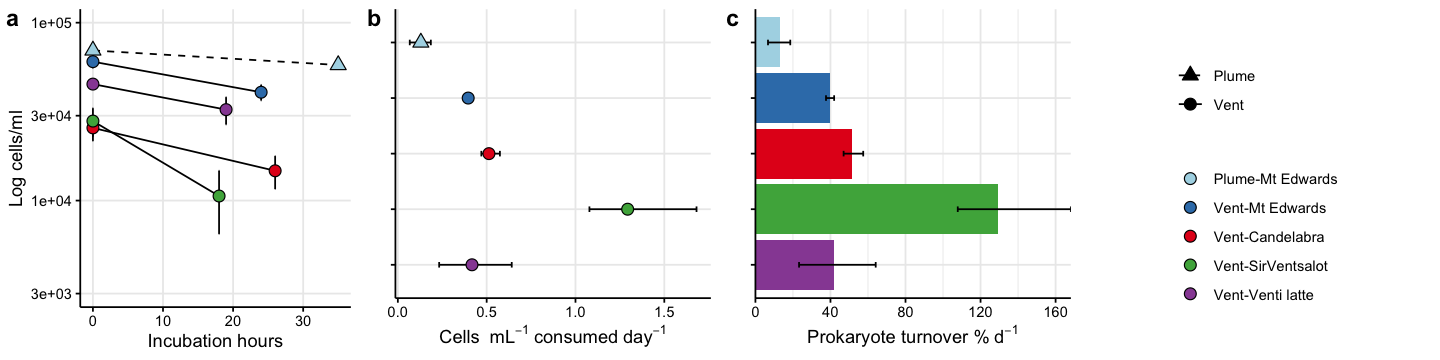

In [19]:
# Combine all plots
options(repr.plot.width = 12, repr.plot.height = 3)
leg <- get_legend(plot_graze_trends)

# svg("Grazing-results-finalplot.svg", h = 3, w = 12)
plot_grid(plot_graze_trends + theme(legend.position = "none"),
          mortality + theme(axis.text.y = element_blank()),
          bar_plot + theme(axis.text.y = element_blank()), leg,
          axis = c("bt", "bt", "bt", "l"), align = "v", labels = c("a", "b", "c", ""), nrow = 1)
# dev.off()

In [20]:
## Save supplementary tables:
# write_delim(graze_rate, path = "Grazing-calc-results.txt", delim = "\t")

In [21]:
prok_avg$BOTTLE = "in situ"
colnames(prok_avg)[2] <- "cellmL"
x <- as.character(unique(flp_long_toplot$SAMPLE))
prok_tmp <- filter(prok_avg, SAMPLE %in% x)
head(prok_tmp)

,SAMPLE,cellmL,BOTTLE
,<chr>,<dbl>,<chr>
1,Plume-Mt Edwards,51959.11,in situ
2,Vent-Candelabra,55076.66,in situ
3,Vent-Mt Edwards,51439.52,in situ
4,Vent-SirVentsalot,52998.29,in situ
5,Vent-Venti latte,111192.50,in situ


In [22]:
t0_flp <- flp_long_toplot %>%
    filter(Tx == "T0") %>%
    select(SAMPLE, BOTTLE, cellmL) %>%
    data.frame
# t0_flp

# Combine
t0_insitu_counts <- rbind(t0_flp, prok_tmp); t0_insitu_counts

SAMPLE,BOTTLE,cellmL
<chr>,<fct>,<dbl>
Plume-Mt Edwards,Control,40027.85
Plume-Mt Edwards,Experimental,69818.95
Vent-Mt Edwards,Control,50556.80
Vent-Mt Edwards,Experimental,60381.13
Vent-Venti latte,Control,47761.10
Vent-Venti latte,Experimental,45154.57
Vent-Candelabra,Control,78574.20
Vent-Candelabra,Experimental,25622.60
Vent-SirVentsalot,Control,56593.85


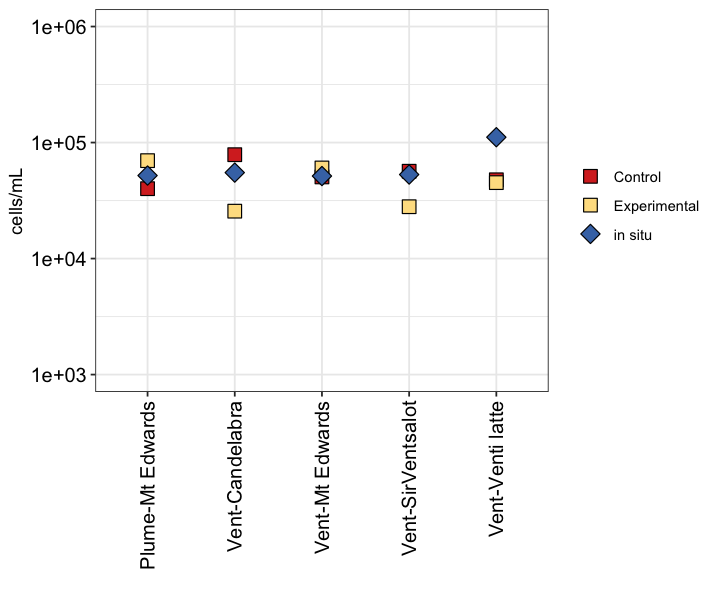

In [23]:
# Plot distribution of counts
options(repr.plot.width = 6, repr.plot.height = 5)

# svg("flp-insitu-prok-counts.svg", w = 6, h = 5)
ggplot(t0_insitu_counts, aes(x = SAMPLE, y = cellmL, fill = BOTTLE, shape = BOTTLE)) +
    geom_point(stat = "identity", size = 4) +
    scale_y_log10(limits = c(1e3,1e6)) +
    scale_fill_manual(values = c("#d73027", "#fee090", "#4575b4")) +
    scale_shape_manual(values = c(22, 22, 23)) +
    labs(x = "", y = "cells/mL") +
    theme_bw() +
    theme(legend.title = element_blank(),
         axis.text.x = element_text(angle = 90, color = "black", size = 12, hjust = 1, vjust = 0.5),
         axis.text.y = element_text(color = "black", size = 12))
# dev.off()

## Carbon calculations

In [24]:
head(graze_rate)

,SAMPLE,SampleOrigin,Bottle,Vent.name,SAMPLE_ORDER,BOTTLE,cellmL_T0,cellmL_Tf,sem_T0,sem_Tf,Hrs_Tf,prok_avg,rate,rate_min,rate_max,Prok_turnover,Prok_turnover_min,Prok_turnover_max
,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Plume-Mt Edwards,Plume,Exp,Mt Edwards,Plume-Mt Edwards,Experimental,69818.95,57808.35,6594.5107,472.550,35,51959.11,0.1294438,0.06703935,0.1857493,12.94438,6.703935,18.57493
2,Vent-Mt Edwards,Vent,Exp,Mt Edwards,Vent-Mt Edwards,Experimental,60381.13,40639.10,4786.6367,4095.400,24,51439.52,0.3959460,0.41957541,0.3762200,39.59460,41.957541,37.62200
3,Vent-Venti latte,Vent,Exp,Venti latte,Vent-Venti latte,Experimental,45154.57,32448.30,670.3404,5670.600,19,111192.50,0.4174021,0.64113500,0.2325695,41.74021,64.113500,23.25695
4,Vent-Candelabra,Vent,Exp,Candelabra,Vent-Candelabra,Experimental,25622.60,14701.50,3964.4107,3079.078,26,55076.66,0.5127925,0.57456692,0.4700572,51.27925,57.456692,47.00572
5,Vent-SirVentsalot,Vent,Exp,SirVentsalot,Vent-SirVentsalot,Experimental,27985.33,10606.10,5055.5143,4108.875,18,52998.29,1.2936683,1.68141744,1.0785052,129.36683,168.141744,107.85052


In [99]:
# 148 fg C/um3 (Gundersen et al. 2002)
# Vol of a sphere
# (4/3)pi*r^3
## Assuming a bacteria sphere is 2um in length, therefore r=1
bac_cell <- ((4/3) * pi * (1^3)) * 148 #units = fg C / cell
bac_cell

[1] 619.941

In [107]:
c_calc <- graze_rate %>% 
    select(SAMPLE, SampleOrigin, prok_avg, starts_with("rate"), Prok_turnover) %>% 
    # Calculate total cells potentially consumed
    mutate(cells_consumed_avg = (prok_avg * rate)) %>% 
#           cells_consumed_min = (prok_avg * rate_min),
#           cells_consumed_max = (prok_avg * rate_max)) %>% 
    # Calculate different carbon amounts
    mutate(morono_C = ((86*cells_consumed_avg) * (1*10^-6)),
          whitman_C = ((20*cells_consumed_avg) * (1*10^-6)),
          parkes_C = ((65*cells_consumed_avg) * (1*10^-6))) %>% 
#           gunderson_C = ((bac_cell*cells_consumed_avg) * (1*10^-6))) %>% 
    data.frame

In [108]:
c_calc

SAMPLE,SampleOrigin,prok_avg,rate,rate_min,rate_max,Prok_turnover,cells_consumed_avg,morono_C,whitman_C,parkes_C
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Plume-Mt Edwards,Plume,51959.11,0.1294438,0.06703935,0.1857493,12.94438,6725.786,0.5784176,0.1345157,0.4371761
Vent-Mt Edwards,Vent,51439.52,0.3959460,0.41957541,0.3762200,39.59460,20367.275,1.7515856,0.4073455,1.3238729
Vent-Venti latte,Vent,111192.50,0.4174021,0.64113500,0.2325695,41.74021,46411.988,3.9914310,0.9282398,3.0167793
Vent-Candelabra,Vent,55076.66,0.5127925,0.57456692,0.4700572,51.27925,28242.900,2.4288894,0.5648580,1.8357885
Vent-SirVentsalot,Vent,52998.29,1.2936683,1.68141744,1.0785052,129.36683,68562.216,5.8963506,1.3712443,4.4565441


In [109]:
car_plot <- c_calc %>% 
    pivot_longer(cols = ends_with("_C"), names_to = "C_CONVERSION", values_to = "C_biomass") %>% 
    mutate(perc_low = 100*(C_biomass/17.3),
          perc_hi = 100*(C_biomass/321.4))

In [110]:
car_plot

SAMPLE,SampleOrigin,prok_avg,rate,rate_min,rate_max,Prok_turnover,cells_consumed_avg,C_CONVERSION,C_biomass,perc_low,perc_hi
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Plume-Mt Edwards,Plume,51959.11,0.1294438,0.06703935,0.1857493,12.94438,6725.786,morono_C,0.5784176,3.3434543,0.17996814
Plume-Mt Edwards,Plume,51959.11,0.1294438,0.06703935,0.1857493,12.94438,6725.786,whitman_C,0.1345157,0.7775475,0.04185305
Plume-Mt Edwards,Plume,51959.11,0.1294438,0.06703935,0.1857493,12.94438,6725.786,parkes_C,0.4371761,2.5270294,0.13602243
Vent-Mt Edwards,Vent,51439.52,0.3959460,0.41957541,0.3762200,39.59460,20367.275,morono_C,1.7515856,10.1247724,0.54498619
Vent-Mt Edwards,Vent,51439.52,0.3959460,0.41957541,0.3762200,39.59460,20367.275,whitman_C,0.4073455,2.3545982,0.12674097
Vent-Mt Edwards,Vent,51439.52,0.3959460,0.41957541,0.3762200,39.59460,20367.275,parkes_C,1.3238729,7.6524442,0.41190817
Vent-Venti latte,Vent,111192.50,0.4174021,0.64113500,0.2325695,41.74021,46411.988,morono_C,3.9914310,23.0718556,1.24188893
Vent-Venti latte,Vent,111192.50,0.4174021,0.64113500,0.2325695,41.74021,46411.988,whitman_C,0.9282398,5.3655478,0.28881138
Vent-Venti latte,Vent,111192.50,0.4174021,0.64113500,0.2325695,41.74021,46411.988,parkes_C,3.0167793,17.4380304,0.93863698


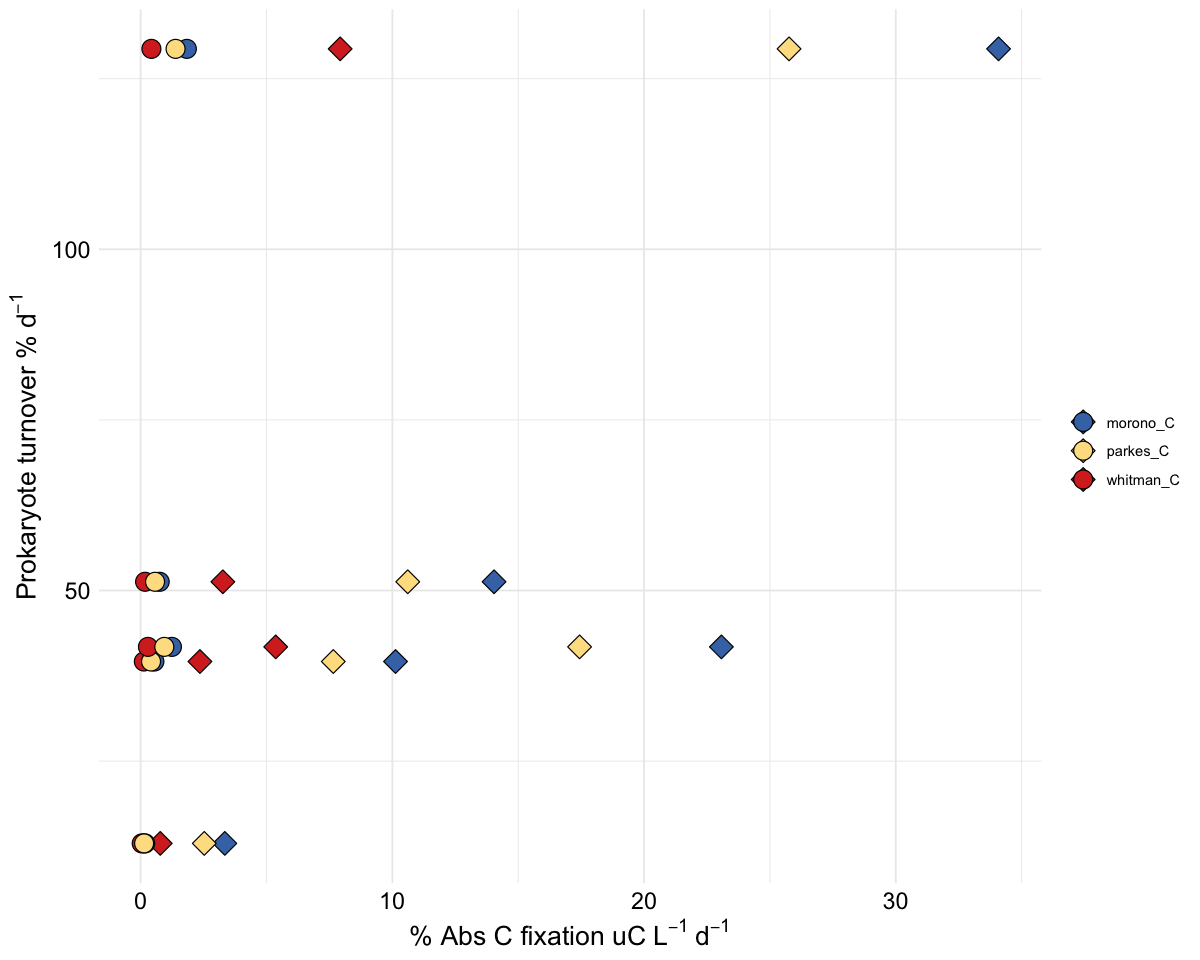

In [111]:
options(repr.plot.width = 10, repr.plot.height = 8)


ggplot(car_plot) +
#     geom_segment(data = car_plot, aes(y = Prok_turnover, yend = Prok_turnover,
#                               x = perc_low, xend = perc_hi, color = C_CONVERSION)) +
    geom_point(stat = "identity", aes(x = perc_low, y = Prok_turnover, fill = C_CONVERSION), 
               shape = 23, color = "black", size = 5) +
    geom_point(stat = "identity", aes(x = perc_hi, y = Prok_turnover, fill = C_CONVERSION),
              shape = 21, color = "black", size = 5) +
    scale_fill_manual(values = c("#4575b4", "#fee090", "#d73027", "#1a9850")) +
    labs(x = bquote("% Abs C fixation uC"~L^-1 ~d^-1),
        y = bquote("Prokaryote turnover %"~d^-1)) +
    theme_minimal() +
    theme(axis.text = element_text(color = "black", size = 14),
          axis.title = element_text(face = "bold", color = "black", size = 16),
         legend.title = element_blank())

In [ ]:
# Assuming we have a grazing rate range and a range of C cels...

In [90]:
# Create modeled dataframe
## Grazing rate range (cells per ml per day)
grazerate = seq(0, 1.5, by = 0.01)

# range of C cell (fg C per cell)
cellC = seq(20,90, by = 0.01)

In [91]:
grazerate

[1] 0.00 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.10 0.11 0.12 0.13 0.14
 [16] 0.15 0.16 0.17 0.18 0.19 0.20 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 [31] 0.30 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.40 0.41 0.42 0.43 0.44
 [46] 0.45 0.46 0.47 0.48 0.49 0.50 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59
 [61] 0.60 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.70 0.71 0.72 0.73 0.74
 [76] 0.75 0.76 0.77 0.78 0.79 0.80 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89
 [91] 0.90 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00 1.01 1.02 1.03 1.04
[106] 1.05 1.06 1.07 1.08 1.09 1.10 1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19
[121] 1.20 1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29 1.30 1.31 1.32 1.33 1.34
[136] 1.35 1.36 1.37 1.38 1.39 1.40 1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49
[151] 1.50

In [ ]:
## Last updated SKH - May 20, 2020